# Modelo SIR

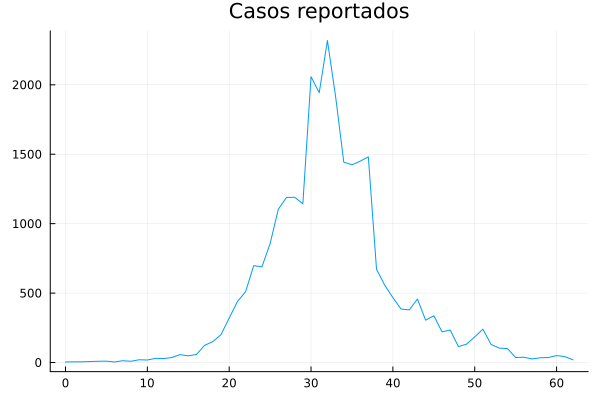

In [1]:
#using ExcelFiles
#using DataFrames
using Plots

#data_frame = DataFrame(load("pandemic_infuenza_SF_1918.xls", "Sheet1"))  # Cambia "Hoja1" por el nombre de tu hoja
#Time = data_frame[:,2][6:end]
#Cases = data_frame[:,3][6:end] 
Data = [0 4; 1 5; 2 5; 3 7; 4 9; 5 10; 6 4; 7 13; 8 9; 9 20; 10 18; 
        11 30; 12 29; 13 36; 14 57; 15 48; 16 58; 17 124; 18 150; 19 201; 20 320; 
        21 438; 22 510; 23 698; 24 689; 25 856; 26 1104; 27 1189; 28 1190; 29 1143; 30 2058; 
        31 1943; 32 2319; 33 1916; 34 1443; 35 1424; 36 1450; 37 1481; 38 672; 39 557; 40 467; 
        41 385; 42 379; 43 457; 44 305; 45 337; 46 221; 47 234; 48 115; 49 132; 50 185; 
        51 240; 52 130; 53 104; 54 100; 55 36; 56 38; 57 26; 58 34; 59 36; 60 50; 
        61 43; 62 19]

Time = Data[:,1]
Cases = Data[:,2]
plot(Time,Cases, label=false, title="Casos reportados")

In [37]:
using DelimitedFiles
using Distributions
using DifferentialEquations

mutable struct ForwardMapping
    mu::Float64
    xi::Float64
    N::Float64
    sigma::Float64
    gamma::Float64
    Pobs::Float64
    beta0::Float64
    flu_data::Vector{Float64}
    flu_time::Vector{Float64}
    weights::Vector{Float64}
end

function ForwardMapping()
    mu = 1.0 / (75.0 * 365.0)
    xi = 0.0
    N = 550000.0
    sigma = 1.0 / 3.0
    gamma = 1.0 / 5.0
    Pobs = 0.75
    beta0 = 1.8 * (sigma + mu) * (gamma + mu) / sigma
    
    flu_data = Cases
    flu_time = Time
    
    weights = ones(11)
    weights[1] = 0.5
    weights[end] = 0.5
    
    return ForwardMapping(mu, xi, N, sigma, gamma, Pobs, beta0, flu_data, flu_time, weights)
end

function rhs(fm::ForwardMapping, x, t, p)
    fx = zeros(3)
    inc = p[1] * x[2]
    fx[1] = (inc + fm.xi) * (1.0 - x[1] - x[2] - x[3]) - (fm.sigma + fm.mu) * x[1]
    fx[2] = fm.sigma * x[1] - (fm.gamma + fm.mu) * x[2]
    fx[3] = fm.gamma * x[2] - fm.mu * x[3]
    return fx
end

function soln(fm::ForwardMapping, p)
    x0 = [p[2], p[3], p[4]]
    return solve((t, x, dx) -> rhs(fm, x, t, p), x0, fm.flu_time)
end

function solve(fm::ForwardMapping, p)
    x0 = [p[2], p[3], p[4]]
    nn = length(fm.flu_time)
    dt = 1.0 / nn
    n_quad = 10 * nn + 1
    t_quad = range(fm.flu_time[1], fm.flu_time[end], length=n_quad)
    soln = solve((t, x, dx) -> rhs(fm, x, t, p), x0, t_quad)
    result = zeros(nn)
    
    for k in 1:nn
        x_e = soln(t_quad[10k:10(k+1)], p[1])
        incidence = fm.sigma .* x_e .* fm.N
        result[k] = dt * dot(fm.weights, incidence)
    end
    
    return fm.Pobs * result
end

if abspath(PROGRAM_FILE) == @__FILE__
    fm = ForwardMapping()
    
    function energy(q)
        mu = solve(fm, q)
        omega = 1.0
        theta = 2.0 / 3.0
        r = mu / (omega - 1.0 + theta * mu)
        p = 1.0 / (omega + theta * mu)
        log_likelihood = sum(logpdf(NegativeBinomial(r, p), fm.flu_data))
        log_prior = 0.0
        log_prior += logpdf(Gamma(1.0, fm.beta0), q[1])
        log_prior += logpdf(Beta(2.0, 5.0), q[2])
        log_prior += logpdf(Beta(2.0, 5.0), q[3])
        log_prior += logpdf(Beta(2.0, 5.0), q[4])
        println(-log_likelihood - log_prior)
        return -log_likelihood - log_prior
    end

    function support(p)
        rt = true
        rt &&= (0.0 < p[1] < 5.0)
        rt &&= (0.0 < p[2] < 1.0)
        rt &&= (0.0 < p[3] < 1.0)
        rt &&= (0.0 < p[4] < 1.0)
        rt &&= (p[2] + p[3] + p[4] < 1.0)
        return rt
    end

    function init()
        p = zeros(4)
        p[1] = rand(Uniform(0.0, 1.0))
        p[2] = rand(Uniform(0.0, 0.1))
        p[3] = rand(Uniform(0.0, 0.1))
        p[4] = rand(Uniform(0.0, 0.1))
        return p
    end
end


LoadError: ArgumentError: Package DifferentialEquations not found in current path.
- Run `import Pkg; Pkg.add("DifferentialEquations")` to install the DifferentialEquations package.

In [2]:
function MetEuler(f, p, y0, t0, tn, h)
    # f: función que define la EDO dy/dt = f(t, y; p)
    # y0: condición inicial
    # t0: tiempo inicial
    # tn: tiempo final
    # h: tamaño del paso
    # p: parámetros de la función f

    # Número de pasos
    n_steps = Int((tn - t0) / h)

    #Dimensión de y0
    d = size(x0)[1]
    
    t_values = zeros(n_steps + 1)
    y_values = zeros(d,n_steps + 1)

    # Acondiciones iniciales
    t_values[1] = t0
    y_values[:,1] = y0

    # Método de Euler
    for i in 1:n_steps
        t_values[i + 1] = t_values[i] + h
        y_values[:,i + 1] = y_values[:,i] + h * f(t_values[i], y_values[:,i],p)
    end

    return t_values, y_values
end

MetEuler (generic function with 1 method)

**Modelo matemático de la influenza**
En este cuaderno se modela el comportamiento de la gripe española en San Francisco de 1918 a 1919.
$$
\begin{align*}
 \dot{S} &= \mu N - \beta \frac{I}{N}S - \xi S - \mu S \\
 \dot{I} &= \beta \frac{I}{N}S + \xi S - \gamma  I - \mu I\\
 \dot{R} &= \gamma I - \mu R
\end{align*}
$$
donde $N = S + I + R$ y $\dot{N} = 0$. Los parámetros $\mu,\xi, N$ y $\gamma$ son conocidos. Con el modelo anteriormente mencionado se quiere hallar el número de reproducción $\mathcal{R}$ y los parámetros $\beta, I(0)$ y $R(0)$.

In [ ]:
#Valores inciales
mu0 = 0.001
S0 = 30000

xi0 = 0.01
gamma = 0.05


In [27]:
function rhs(t,x,p)
    # Parámetros
    mu = p[1]
    beta = p[2]
    xi = p[3]
    gamma = p[4]

    # Variables
    S = x[1]
    I = x[2]
    R = x[3]
    N = S + I + R

    # Ecuaciones 
    St = mu* N - beta*I*S/N - xi*S-mu*S
    It = beta*I*S/N + xi*S - gamma*I- mu*I
    Rt = gamma*I - mu*R
    Ct = It + Rt

    return [St,It,Rt,Ct]
end


function sol_num(p,SIR0)
    return MetEuler(rhs, p, SIR0, 0, 62, 1)
end

sol_num (generic function with 1 method)

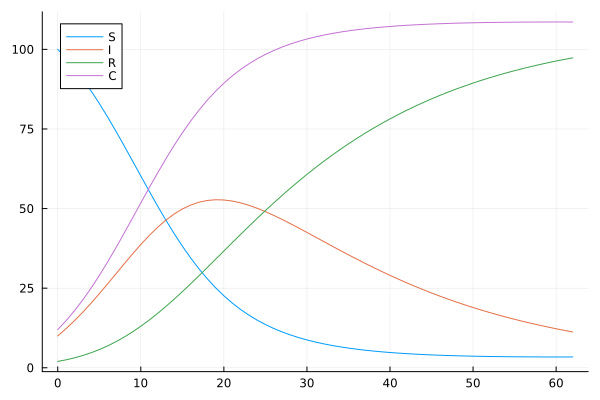

In [34]:
p0 = [0.001; 0.2; 0.01; 0.05]
x0 = [100; 10; 2;12]
T, SIR = sol_num(p0,x0)

plot(T,SIR[1,:],label="S")
plot!(T,SIR[2,:],label="I")
plot!(T,SIR[3,:],label="R")
plot!(T,SIR[4,:],label="C")

In [36]:
function ki(n)
    S = SIR[1,:]
    I = SIR[2,:]
    R = SIR[3,:]
    N = SIR[1,1] + SIR[2,1] + SIR[3,1]
    return 
end

63-element Vector{Float64}:
  0.0
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
 11.0
 12.0
  ⋮
 51.0
 52.0
 53.0
 54.0
 55.0
 56.0
 57.0
 58.0
 59.0
 60.0
 61.0
 62.0

In [ ]:
function energia(p)
    # Parámetros
    mu = p[1]
    beta = p[2]
    xi = p[3]
    gamma = p[4]
    
end